In [2]:
# general
import os
import numpy as np
# jax
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax import jit
from jax import grad
from jax import vmap
from jax import jacobian
from jax import jacfwd, jacrev
from jax import vjp
from jax.lax import scan
# plotting
import matplotlib.pyplot as plt
import arviz
# numpyro
import numpyro
import numpyro.distributions as npyro_dist
from numpyro.infer import MCMC, NUTS
# # NF
import torch
import pyro
import pyro.distributions as pyro_dist
import pyro.distributions.transforms as T
smoke_test = ('CI' in os.environ)

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Development notebook 5
$\providecommand{\d}{\mathrm{d}}$
$\providecommand{\D}{\mathcal{D}}$

Now we consider the problem of the normalization. Previously, we developed the sampling method to estimate the partition function. The idea was to descretize the time to have finite dimensional integral.

$$
\tau' \rightarrow \tau' = i\epsilon
$$
where $\epsilon=1/n_\tau$. With this discretization, we have

$$
Z = \int \D x e^{iS} \rightarrow Z = \int\d x e^{iS}
$$

and 

$$
S = \sum_{i=1}^{n_\tau} \epsilon L_i
$$

where $L_i$ is the discretized Lagrangian.

Using the Lefschetz thimble we can eliminate the unwanted oscilationary feature of integrand

$$
Z = \int \d x \left|\frac{\partial z}{\partial x}\right| e^{i S[z(x)]}
$$

where $z$ is the analytic continuation of $x$ and can be obtained by solving flow equation, so the $z$ is the determinic function of $x$, i.e. $z=z(x)$.

We now split the integrand to amlitude and phase

$$
Z = \int \d x |Je^{h}| e^{iH+i\varphi_J}
$$

where $iS = h+iH$, $J=\partial z/\partial x = |J| e^{i\varphi_J}$.

Now the amplitude is positive, and can be interpreted as probability, and no sign problem happens thanks to the Lefshcetz thimble approach.
If we can have a nice proposal distibution $P$, we can evalute the partition function $Z$ by importance sampling with the distribution function.

$$
\hat{Z} = \langle |Je^{h}| e^{iH+i\varphi_J} \rangle_P = \frac{1}{M}\sum_{j=1}^{M} \frac{|Je^{h}| e^{iH+i\varphi_J} (x_j)}{P(x_j)}
$$

where $M$ is the number of samples. The question is how to get the proposal distribution function $P$.

### Normal distribution

Of course the ideal distribution $P$ would not be the normal distribution, but we can make it a try. 
Since the integrand will drop off at large $x$ due to the Lefschetz thimble after flow, we expect the normal distribution is more or less a good proposal.

Procedure is following
1. Sample from $|Je^{h}|$ with HMC (or we can also do uniform sampling)
2. From the samples, we compute the mean $\mu$ and covariance matrix $C$.
3. With the obtained mean and covariance matrix, we define the proposal distribution by multivariate normal distribution, i.e. $P=\mathcal{N}(\mu, C)$.
4. Using the proposal distribution, we perform importance sampling to get $\hat{Z}$.


### Example problem
Here we consider an example problem of $n$-dimensional Fresnel integral

$$
Z = \int \d^n \bm{x} e^{i |\bm{x}|^2} = \left[\int\d x e^{ix^2}\right]^n = \left[(1+i)\sqrt{\pi/2}\right]^n
$$

In [3]:
def action_iphi(z):
    z2 = jnp.sum(z**2)
    iphi = 1j*z2
    # iphi = 1j*(z2/2 + 2/(1+z2))
    return iphi

def action_h(z):
    s = action_iphi(z)
    h = jnp.real(s) + 0.0j
    return h

def action_Seff(z):
    seff = -action_iphi(z)
    return seff

def integrand(z):
    return jnp.exp(action_iphi(z))

# # corresponding gradients
grad_iphi = grad(action_iphi, holomorphic=True)
grad_h    = grad(action_h, holomorphic=True)
grad_Seff = grad(action_Seff, holomorphic=True)

In [4]:
def flow_step(z, ds, thre=0.1):
    # dSdz = grad_Seff(z)
    # z = z - ds*dSdz
    dhdz = grad_h(z)
    z = z + ds*dhdz
    return z

def flow_n_steps(z, ds, n_step):
    fnc = lambda z, null: (flow_step(z, ds), null)
    z, null = scan(fnc, z, length=n_step)
    return z

def flow_n_steps_with_jac(z, ds, n_step):
    z = flow_n_steps(z, ds, n_step)
    j = jacrev(flow_n_steps, argnums=0, holomorphic=True)(z, ds, n_step)
    j = jnp.linalg.det(j)
    return z, j

vflow = vmap(flow_n_steps_with_jac, (0,None,None), 0)

In [5]:
def model():
    # Define a prior for `x`
    x = []
    for i in range(ndim):
        xi = numpyro.sample('x{}'.format(i+1), npyro_dist.Uniform(-3, 3))
        x.append(xi)
    x = jnp.array(x)

    # flow
    z = jnp.astype(x, complex)
    # n_step in flow should be optimized depending on the dimension...
    z_pl, j = flow_n_steps_with_jac(z, 1e-3, 400)
    i = integrand(z_pl)

    amplt = jnp.abs(i*j)
    phase = i*j/amplt

    # likelihood
    numpyro.factor('loglike', jnp.log(amplt))

    # save derived parameters
    numpyro.deterministic('phase'    , phase)
    numpyro.deterministic('amplitude', amplt)

In [6]:
def plot_rcc(cov, s=2):
    std = jnp.diag(cov)**0.5
    rcc = cov/jnp.outer(std, std)
    ndim = std.size

    plt.figure(figsize=(s,s))
    plt.title('{} dim'.format(ndim))
    plt.imshow(rcc, cmap='bwr', vmin=-1, vmax=1)
    plt.show()

In [7]:
%%time
ndim = 8*4 + 1
# ndim = 5
# Set up and run the HMC sampler
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=10000)
mcmc.run(jax.random.PRNGKey(0))

# Get samples
samples = mcmc.get_samples()
# convert to jnp
samples = jnp.transpose(jnp.array([samples['x{}'.format(i+1)] for i in range(ndim)]))

sample: 100%|██████████| 10500/10500 [00:50<00:00, 208.10it/s, 7 steps of size 4.60e-01. acc. prob=0.90] 


CPU times: user 55.6 s, sys: 1.85 s, total: 57.4 s
Wall time: 59.9 s


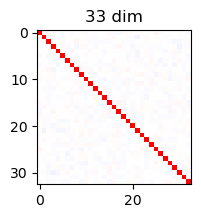

In [8]:
mu = jnp.mean(samples, axis=0)
cov= jnp.cov(samples.T)
plot_rcc(cov)

In [9]:
%%time

# rescale covariance to avoid numerical instability
mu = jnp.mean(samples, axis=0)
cov= jnp.cov(samples.T)

# sample from the proposal distribution
key = jax.random.PRNGKey(0)
x = jax.random.multivariate_normal(key, mu, cov, 1000).astype(complex)
logp = jsp.stats.multivariate_normal.logpdf(x, mu, cov)

# evaluate the integrand and integrate
z_pl, j = vflow(x, 1e-3, 400)
i = vmap(integrand)(z_pl)
Z_pl = jnp.mean(i*j*jnp.exp(-logp))      / jnp.pi**(ndim/2)
Z_ana= ((1+1j)*jnp.sqrt(jnp.pi/2))**ndim / jnp.pi**(ndim/2)
err  = jnp.abs(Z_pl-Z_ana)/jnp.abs(Z_ana)

print('Z_pl:', Z_pl)
print('Z_ana:', Z_ana)
print('err:', err)
# <- Perfect!!

Z_pl: (0.7030492+0.70746696j)
Z_ana: (0.707107+0.7071073j)
err: 0.0040737297
CPU times: user 3.97 s, sys: 233 ms, total: 4.2 s
Wall time: 3.12 s


### Additional test: what if the proposal dist. is uniform?

In [10]:
wprior = 3
key = jax.random.PRNGKey(0)
x = jax.random.uniform(key, (2000, ndim), minval=-wprior, maxval=wprior)
logp = -ndim*jnp.log((2*wprior))

z_pl, j = vflow(x.astype(complex), 1e-3, 400)
i = vmap(integrand)(z_pl)
Z_pl = jnp.mean(i*j*jnp.exp(-logp))      / jnp.pi**(ndim/2)
Z_ana= ((1+1j)*jnp.sqrt(jnp.pi/2))**ndim / jnp.pi**(ndim/2)
err  = jnp.abs(Z_pl-Z_ana)/jnp.abs(Z_ana)

print('Z_pl:', Z_pl)
print('Z_ana:', Z_ana)
print('err:', err)
# <- soooooooo bad

Z_pl: (9.052048e-10-2.957961e-10j)
Z_ana: (0.707107+0.7071073j)
err: 1.0
